In [113]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mnist-dataset/train-images.idx3-ubyte
/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte
/kaggle/input/mnist-dataset/train-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte
/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte
/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


In [114]:
print("hello trial")

hello trial


# Question 3

Train on MNIST dataset using an MLP. The original training dataset contains 60,000 images and test contains 10,000 images. If you are short on compute, use a stratified subset of a smaller number of images. But, the test set remains the same 10,000 images. Compare against RF and Logistic Regression models.  The metrics can be: F1-score, confusion matrix. What do you observe? What all digits are commonly confused? 

Let us assume your MLP has 30 neurons in first layer, 20 in second layer and then 10 finally for the output layer (corresponding to 10 classes). On the trained MLP, plot the t-SNE for the output from the layer containing 20 neurons for the 10 digits. Contrast this with the t-SNE for the same layer but for an untrained model. What do you conclude? 

Now, use the trained MLP to predict on the Fashion-MNIST dataset. What do you observe? How do the embeddings (t-SNE viz for the second layer compare for MNIST and Fashion-MNIST images) [3 marks]

# Essential Libraries and pre-req

In [115]:
import torch

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import struct

In [116]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

GRAYSCALE = False

Using device: cuda


# Pre-processing

In [117]:
train_images_path = '/kaggle/input/mnist-dataset/train-images.idx3-ubyte'
train_labels_path = '/kaggle/input/mnist-dataset/train-labels.idx1-ubyte'
test_images_path = '/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte'
test_labels_path = '/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte'

def load_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [118]:
X_train = load_idx(train_images_path)
y_train = load_idx(train_labels_path)
X_test = load_idx(test_images_path)
y_test = load_idx(test_labels_path)

In [119]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)
y_train shape: (60000,)
y_test shape: (10000,)


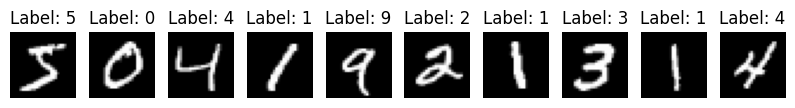

In [120]:
def plot_images(images, labels, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

plot_images(X_train, y_train, num_images=10)#plotting first 10 images

In [121]:
#train-test split = 86-14 (approx), transforming them to torch tensors
X_train_torch = torch.from_numpy(X_train)
y_train_torch = torch.from_numpy(y_train)
X_test_torch = torch.from_numpy(X_test)
y_test_torch = torch.from_numpy(y_test)

In [122]:
X_train_torch = X_train_torch.view(-1, 28*28)

In [123]:
X_train_torch.shape #flatening out the input

torch.Size([60000, 784])

In [124]:
from torch.utils.data import DataLoader, TensorDataset, random_split

In [125]:
train_size = int(0.9 * len(X_train_torch))  #90% for training
val_size = len(X_train_torch) - train_size  #10% for validation

In [126]:
def make_train_val(X_train_torch,y_train_torch,train_size=train_size, val_size = val_size):
    train_dataset, val_dataset = random_split(TensorDataset(X_train_torch, y_train_torch), [train_size, val_size])
    batch_size = 64  
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    return train_loader, val_loader

## MLP

In [127]:
#from NN api of pytorch
from torch import Tensor                  #tensor node in the computation graph
import torch.nn as nn                     #neural networks
import torch.nn.functional as F           #layers, activations and more
import torch.optim as optim               #optimizers e.g. gradient descent, ADAM, etc.

In [128]:
class MLP(nn.Module):
    def __init__(self, input_size, fc1_units=128, fc2_units=64, fc3_units=32):
        super().__init__()
        self.fc1 = nn.Linear(input_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, 10)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))         
        x = F.relu(self.fc2(x))          
        x = F.relu(self.fc3(x))          
        x = self.fc4(x)     
        return x


In [129]:
model_example = MLP(28*28)

In [130]:
total_params = sum(p.numel() for p in model_example.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 111146


In [131]:
model_layers_list = [[256, 128, 64], [128,64,32], [64, 32, 16]] #architecture 1,2,3

![Cross entropy loss](https://discuss.pytorch.org/uploads/default/original/3X/6/d/6d49a23c573bcb2997233aca196fc6e463da4621.png)

In [132]:
def model_development(l1,l2,l3):    
    model = MLP(28*28,l1,l2,l3)
    optimizer = optim.Adam(model.parameters(), lr=0.0005)  

    criterion = nn.CrossEntropyLoss()
    return model, optimizer, criterion
'''
why adam?

It adapts the learning rate for each parameter based on the magnitude of the gradient, which helps to avoid getting stuck in local minima.
It uses a moving average of the gradient to estimate the second moment (i.e., the variance) of the gradient, which helps to stabilize the optimization process.

'''

'\nwhy adam?\n\nIt adapts the learning rate for each parameter based on the magnitude of the gradient, which helps to avoid getting stuck in local minima.\nIt uses a moving average of the gradient to estimate the second moment (i.e., the variance) of the gradient, which helps to stabilize the optimization process.\n\n'

In [133]:
class EarlyStopping:
    def __init__(self, patience=3, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

## MLP Training

In [134]:
def set_seed(seed_value=2):
    torch.manual_seed(seed_value) #random weight intialization
    torch.cuda.manual_seed(seed_value) #incase I use GPU ahead
    np.random.seed(seed_value) #numpy

In [135]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    set_seed()  
    
    early_stopping = EarlyStopping(patience=5)

    for epoch in range(num_epochs):
        #Training 
        model.train()
        train_loss = 0
        num_batches = len(train_loader)
        print_interval = num_batches // 5  #Print 5 times per epoch

        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            optimizer.zero_grad()
            y_pred = model(X_batch.float())  #Convert inputs to float
            loss = criterion(y_pred, y_batch.long())  #Convert labels to long
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            #Print progress 5 times per epoch
            if (batch_idx + 1) % print_interval == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}/{num_batches}, '
                      f'Train Loss: {train_loss / (batch_idx + 1):.4f}')
        
         # Validation phase
        val_loss = 0
        model.eval()
        correct = 0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                y_pred_val = model(X_val.float())  
                loss = criterion(y_pred_val, y_val.long())  
                val_loss += loss.item()
                _, predicted = torch.max(y_pred_val, 1)
                correct += (predicted == y_val).sum().item()

        #Calculate average losses and accuracy
        train_loss /= num_batches
        val_loss /= len(val_loader)
        val_accuracy = correct / len(val_loader.dataset)

        #Print validation results at the end of the epoch
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}\n')
        
        # Early stopping check
        early_stopping(val_loss / len(val_loader))
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break        

## MLP Testing

In [136]:
def test_model(model, test_loader, criterion):
    model.eval()
    
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for X_test, y_test in test_loader:
            y_pred_test = model(X_test.float())  # Convert input to float
            loss = criterion(y_pred_test, y_test.long())  # Convert labels to long
            test_loss += loss.item()

            _, predicted = torch.max(y_pred_test, 1)
            correct += (predicted == y_test).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = correct / len(test_loader.dataset)

    #Print test results
#     print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    
    return test_loss, test_accuracy 


In [137]:
def one_try(model_layers, X_test_torch, y_test_torch):
    train_loader, val_loader = make_train_val(X_train_torch,y_train_torch,train_size=train_size, val_size = val_size)
    model, optimizer, criterion = model_development(model_layers[0], model_layers[1], model_layers[2])
    train_model(model, train_loader, val_loader, criterion, optimizer, 20)
    X_test_torch = X_test_torch.view(-1, 28*28)  #Reshape to (10000, 784)
    
    batch_size = 64  
    test_dataset = TensorDataset(X_test_torch, y_test_torch)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    loss, accuracy = test_model(model, test_loader, criterion)
    
    return model, loss, accuracy, test_loader

## 3 attempts with different hyper-params

In [138]:
test_loss_list , test_accuracy_list, model_list = [], [], [] 
f1_list, cm_list = [], []

## weights summary

In [139]:
# model.state_dict

In [140]:
# num_params = 0
# for name, param in model.named_parameters():
#     num_params += param.numel()
# print(f"Number of parameters: {num_params}")

## Metrics for MLP

In [141]:
def confusion_matrix_to_dataframe(cm, model_name):
    """
    Converts a confusion matrix into a pandas DataFrame for better readability.
    """
    df_cm = pd.DataFrame(cm, index=[f"Actual {i}" for i in range(10)],
                         columns=[f"Predicted {i}" for i in range(10)])
    df_cm.name = f'{model_name} Confusion Matrix'
    return df_cm

In [142]:
from sklearn.metrics import f1_score, confusion_matrix

![F1 score](https://images.prismic.io/encord/0ef9c82f-2857-446e-918d-5f654b9d9133_Screenshot+%2849%29.png?auto=compress,format)

In [143]:
def evaluate_model_metrics(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_test, y_test in test_loader:
            y_pred_test = model(X_test.float())
            _, predicted = torch.max(y_pred_test, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_test.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    cm = confusion_matrix(all_labels, all_preds)
    
#     print(f'F1 Score: {f1:.4f}')
#     print(f'Confusion Matrix:\n{cm}')
    
    return f1,cm

In [144]:
test_loss_list, test_accuracy_list, model_list = [], [], []
f1_list, cm_list = [], []

for i in range(0, 3):
    #Train and evaluate each model configuration
    model, test_loss, test_accuracy, test_loader = one_try(model_layers_list[i], X_test_torch, y_test_torch)
    
    #Store results
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_accuracy)
    model_list.append(model.state_dict())
    
    #Evaluate model metrics
    f1, cm = evaluate_model_metrics(model, test_loader)
    
    #Store evaluation metrics
    f1_list.append(f1)
    cm_list.append(confusion_matrix_to_dataframe(cm, f"MLP_{i+1}"))

Epoch 1/20, Batch 168/844, Train Loss: 0.5058
Epoch 1/20, Batch 336/844, Train Loss: 0.3716
Epoch 1/20, Batch 504/844, Train Loss: 0.3092
Epoch 1/20, Batch 672/844, Train Loss: 0.2751
Epoch 1/20, Batch 840/844, Train Loss: 0.2505
Epoch 1/20, Train Loss: 0.2502, Val Loss: 0.1495, Val Accuracy: 0.9555

Epoch 2/20, Batch 168/844, Train Loss: 0.1103
Epoch 2/20, Batch 336/844, Train Loss: 0.1098
Epoch 2/20, Batch 504/844, Train Loss: 0.1079
Epoch 2/20, Batch 672/844, Train Loss: 0.1098
Epoch 2/20, Batch 840/844, Train Loss: 0.1092
Epoch 2/20, Train Loss: 0.1092, Val Loss: 0.1376, Val Accuracy: 0.9575

Epoch 3/20, Batch 168/844, Train Loss: 0.0784
Epoch 3/20, Batch 336/844, Train Loss: 0.0766
Epoch 3/20, Batch 504/844, Train Loss: 0.0793
Epoch 3/20, Batch 672/844, Train Loss: 0.0798
Epoch 3/20, Batch 840/844, Train Loss: 0.0820
Epoch 3/20, Train Loss: 0.0819, Val Loss: 0.1087, Val Accuracy: 0.9693

Epoch 4/20, Batch 168/844, Train Loss: 0.0535
Epoch 4/20, Batch 336/844, Train Loss: 0.0538
Ep

In [145]:
# f1,cm = evaluate_model_metrics(model, test_loader)
# print(f'F1 Score: {f1:.4f}\n')
# print(f'Confusion Matrix:\n')
# confusion_matrix_to_dataframe(cm, "MLP => Multi layer perceptron")

In [146]:
for i in range(0,3):
    l1,l2,l3 = model_layers_list[i]
    print(f"\nModel architecture = > \n Input Size = {28*28}, layer 1 = {l1}, layer 2 = {l2}, layer 3 = {l3}, Output = {10}\n")
    print(f'\nTest Loss: {test_loss_list[i]:.4f}, Test Accuracy: {test_accuracy_list[i]:.4f}')
    print(f'F1 Score: {f1_list[i]:.4f}\n')
    print(f'Confusion Matrix:\n')
    df_cm_returned = confusion_matrix_to_dataframe(cm_list[i], "MLP => Multi layer perceptron")
    display(df_cm_returned)
    print("\n\n\n")


Model architecture = > 
 Input Size = 784, layer 1 = 256, layer 2 = 128, layer 3 = 64, Output = 10


Test Loss: 0.1040, Test Accuracy: 0.9749
F1 Score: 0.9749

Confusion Matrix:



,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 0,971,1,1,0,0,1,5,1,0,0
Actual 1,0,1122,3,1,0,3,2,2,2,0
Actual 2,6,1,1002,4,3,0,2,8,4,2
Actual 3,0,0,6,972,0,20,0,2,3,7
Actual 4,2,1,4,0,968,0,3,2,0,2
Actual 5,2,0,0,3,1,880,3,1,1,1
Actual 6,5,4,2,1,4,9,932,0,1,0
Actual 7,3,4,11,3,5,0,0,988,2,12
Actual 8,6,1,1,2,6,8,6,0,939,5
Actual 9,5,3,0,4,16,5,0,1,0,975







Model architecture = > 
 Input Size = 784, layer 1 = 128, layer 2 = 64, layer 3 = 32, Output = 10


Test Loss: 0.1281, Test Accuracy: 0.9710
F1 Score: 0.9710

Confusion Matrix:



,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 0,974,0,1,1,0,1,0,0,2,1
Actual 1,3,1123,3,0,0,0,3,0,2,1
Actual 2,10,1,1002,2,0,0,1,13,1,2
Actual 3,0,1,6,987,0,2,0,7,2,5
Actual 4,5,0,4,0,936,0,2,2,1,32
Actual 5,4,1,0,19,1,849,6,1,5,6
Actual 6,19,3,2,0,6,5,920,0,3,0
Actual 7,2,4,6,0,0,0,0,1005,2,9
Actual 8,11,2,4,4,2,2,4,5,936,4
Actual 9,7,4,0,6,5,3,0,5,1,978







Model architecture = > 
 Input Size = 784, layer 1 = 64, layer 2 = 32, layer 3 = 16, Output = 10


Test Loss: 0.1352, Test Accuracy: 0.9702
F1 Score: 0.9702

Confusion Matrix:



,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 0,964,0,4,1,1,1,2,4,1,2
Actual 1,0,1122,2,1,0,1,2,1,6,0
Actual 2,2,1,1007,3,1,1,1,7,8,1
Actual 3,0,0,3,971,0,10,0,7,14,5
Actual 4,2,1,12,0,948,0,2,4,3,10
Actual 5,1,0,0,7,1,872,4,0,5,2
Actual 6,7,2,1,1,9,12,923,0,3,0
Actual 7,0,7,5,2,2,0,0,1004,6,2
Actual 8,4,1,2,3,7,7,0,3,944,3
Actual 9,0,5,0,9,16,8,0,15,9,947


# Other methods => Random Forest

In [147]:
from sklearn.ensemble import RandomForestClassifier

In [148]:
#Flatten the training data and convert to numpy arrays
X_train_np = X_train_torch.view(-1, 28*28).numpy()
y_train_np = y_train_torch.numpy()
X_test_np = X_test_torch.numpy()
y_test_np = y_test_torch.numpy()

In [149]:
X_test_np.shape

(10000, 28, 28)

In [150]:
def accuracy_score(labels, preds):
    return np.mean(labels == preds)

In [151]:
def one_try_rf(estimator):
    #Reshape the input data from (N, 28, 28) to (N, 784)
    X_test_flattened = X_test_np.reshape(-1, 28*28)

    #Initialize and train the Random Forest model
    random_f_model = RandomForestClassifier(n_estimators=estimator, random_state=2)
    random_f_model.fit(X_train_np, y_train_np)

    #Predict on the flattened test data
    random_f_preds = random_f_model.predict(X_test_flattened)

    #Calculate F1 Score and Confusion Matrix for Random Forest
    random_f_f1 = f1_score(y_test_np, random_f_preds, average='weighted')
    random_f_cm = confusion_matrix(y_test_np, random_f_preds)
    random_f_accuracy = accuracy_score(y_test_np, random_f_preds)

    print(f"\n\nThe number of trees are {estimator}")
    print(f'Random Forest F1 Score: {random_f_f1:.6}')
    print(f'Random Forest Accuracy: {random_f_accuracy}')  
    print('\nRandom Forest Confusion Matrix:\n')
    display(confusion_matrix_to_dataframe(random_f_cm, f"Random Forests_{estimator}"))

In [152]:
rf_trees = [50, 100, 150]

In [153]:
for i in range(0,3):
    trees = rf_trees[i]
    one_try_rf(trees)



The number of trees are 50
Random Forest F1 Score: 0.967878
Random Forest Accuracy: 0.9679

Random Forest Confusion Matrix:



,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 0,968,0,1,0,0,1,4,1,5,0
Actual 1,0,1125,1,3,1,2,2,0,1,0
Actual 2,6,0,997,7,2,0,3,8,8,1
Actual 3,1,0,11,967,0,9,0,11,7,4
Actual 4,3,0,0,0,952,0,5,0,3,19
Actual 5,3,1,2,15,3,856,5,1,4,2
Actual 6,9,3,1,0,5,3,935,0,2,0
Actual 7,1,5,19,2,1,0,0,989,3,8
Actual 8,2,0,5,8,4,5,5,3,933,9
Actual 9,5,6,2,10,12,6,1,4,6,957




The number of trees are 100
Random Forest F1 Score: 0.969785
Random Forest Accuracy: 0.9698

Random Forest Confusion Matrix:



,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 0,968,0,1,0,0,2,4,1,4,0
Actual 1,0,1124,2,3,0,2,2,1,1,0
Actual 2,6,0,998,6,2,0,3,9,8,0
Actual 3,0,0,11,975,0,6,0,9,6,3
Actual 4,1,0,1,0,955,0,5,0,2,18
Actual 5,3,1,1,15,3,857,4,1,4,3
Actual 6,6,3,1,0,4,5,936,0,3,0
Actual 7,1,3,19,1,1,0,0,992,4,7
Actual 8,4,0,4,6,2,6,4,3,936,9
Actual 9,5,6,2,12,14,3,1,3,6,957




The number of trees are 150
Random Forest F1 Score: 0.969383
Random Forest Accuracy: 0.9694

Random Forest Confusion Matrix:



,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 0,969,0,1,0,0,2,3,1,4,0
Actual 1,0,1124,3,2,0,2,2,1,1,0
Actual 2,6,0,999,6,2,0,3,8,8,0
Actual 3,0,0,10,974,0,7,0,9,7,3
Actual 4,1,0,1,0,954,0,5,0,3,18
Actual 5,3,1,2,12,3,857,5,2,4,3
Actual 6,6,3,0,0,5,5,936,0,3,0
Actual 7,1,3,21,1,0,0,0,990,2,10
Actual 8,5,0,4,5,3,6,4,3,935,9
Actual 9,5,6,3,13,13,2,1,4,6,956


## Other methods => Logisitic regression

In [154]:
from sklearn.linear_model import LogisticRegression

In [155]:
def one_try_logreg(max_iter):
    X_test_flattened = X_test_np.reshape(-1, 28*28)
    
    lr_model = LogisticRegression(max_iter=max_iter, random_state=2)
    lr_model.fit(X_train_np, y_train_np)

    logreg_preds = lr_model.predict(X_test_flattened)

    logreg_f1 = f1_score(y_test_np, logreg_preds, average='weighted')
    logreg_cm = confusion_matrix(y_test_np, logreg_preds)
    lr_acc = accuracy_score(y_test_np, logreg_preds)

    print(f"\n\nThe number of iterations are {max_iter}")
    print(f'Logistic Regression F1 Score: {logreg_f1:.6}')
    print(f'Random Forest Accuracy: {lr_acc}')  
    print('\nLogistic Regression Confusion Matrix:\n')
    display(confusion_matrix_to_dataframe(logreg_cm, f"Logistic Regression_{max_iter}"))

In [156]:
logreg_iterations = [500, 1000, 1200]

for max_iter in logreg_iterations:
    one_try_logreg(max_iter)



The number of iterations are 500
Logistic Regression F1 Score: 0.92222
Random Forest Accuracy: 0.9224

Logistic Regression Confusion Matrix:



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 0,954,0,1,4,1,7,7,2,4,0
Actual 1,0,1112,7,2,0,1,3,1,9,0
Actual 2,3,12,921,18,12,6,11,9,36,4
Actual 3,4,2,18,921,2,24,3,10,19,7
Actual 4,2,3,5,4,917,0,10,5,9,27
Actual 5,12,4,3,37,11,762,16,7,33,7
Actual 6,10,3,8,2,6,18,908,1,2,0
Actual 7,1,7,25,10,6,1,0,943,3,32
Actual 8,7,13,6,23,8,20,6,13,867,11
Actual 9,8,6,2,11,24,4,0,22,13,919




The number of iterations are 1000
Logistic Regression F1 Score: 0.920807
Random Forest Accuracy: 0.921

Logistic Regression Confusion Matrix:



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 0,955,0,3,2,1,5,6,4,4,0
Actual 1,0,1109,8,3,0,1,3,2,9,0
Actual 2,5,12,917,17,12,6,11,9,40,3
Actual 3,3,1,18,921,2,23,3,11,22,6
Actual 4,3,3,6,5,909,0,10,5,10,31
Actual 5,12,5,3,36,12,760,17,6,35,6
Actual 6,10,3,9,2,7,17,907,1,2,0
Actual 7,4,7,25,8,4,2,0,946,3,29
Actual 8,7,14,5,21,6,21,10,12,865,13
Actual 9,8,7,1,10,22,7,1,23,9,921




The number of iterations are 1200
Logistic Regression F1 Score: 0.92052
Random Forest Accuracy: 0.9207

Logistic Regression Confusion Matrix:



/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4,Predicted 5,Predicted 6,Predicted 7,Predicted 8,Predicted 9
Actual 0,953,0,4,2,1,6,6,4,4,0
Actual 1,0,1109,8,3,0,1,3,2,9,0
Actual 2,4,13,916,18,12,6,12,8,39,4
Actual 3,3,1,18,922,2,23,2,11,22,6
Actual 4,3,2,7,4,907,0,10,8,10,31
Actual 5,10,5,3,37,12,761,15,6,37,6
Actual 6,9,3,8,2,7,18,908,1,2,0
Actual 7,4,8,23,7,5,2,0,947,2,30
Actual 8,7,15,5,21,6,22,10,13,863,12
Actual 9,7,7,2,9,22,7,1,23,10,921


## T-SNE distributions

In [157]:
from sklearn.manifold import TSNE

In [158]:
def extract_features(model, data_loader):
    """
    Extracts the features from the second last layer (fc3) of the model.
    """
    model.eval()
    features = []
    labels = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.float()
            x = F.relu(model.fc1(X_batch))   #First layer
            x = F.relu(model.fc2(x))          #Second layer
            x = model.fc3(x)                  #Extract from the second last layer (fc3)
            features.append(x.cpu().numpy())
            labels.append(y_batch.cpu().numpy())
    
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

def plot_tsne(features, labels, title):
    """
    Plots the t-SNE visualization for the given features, with distinct colors for each label.
    """
    tsne = TSNE(n_components=2, random_state=4)
    features_2d = tsne.fit_transform(features)

    colors = plt.cm.get_cmap('tab10', 10)  #'tab10' has 10 distinct colors

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap=colors, alpha=0.6)
    plt.colorbar(scatter, ticks=range(10), label='Label')
    plt.clim(-0.5, 9.5)  
    plt.title(title)
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

In [159]:
model_trained, test_loss, test_accuracy, test_loader = one_try([128,64,32], X_test_torch, y_test_torch)    

Epoch 1/20, Batch 168/844, Train Loss: 0.6068
Epoch 1/20, Batch 336/844, Train Loss: 0.4315
Epoch 1/20, Batch 504/844, Train Loss: 0.3624
Epoch 1/20, Batch 672/844, Train Loss: 0.3198
Epoch 1/20, Batch 840/844, Train Loss: 0.2887
Epoch 1/20, Train Loss: 0.2882, Val Loss: 0.1643, Val Accuracy: 0.9522

Epoch 2/20, Batch 168/844, Train Loss: 0.1308
Epoch 2/20, Batch 336/844, Train Loss: 0.1286
Epoch 2/20, Batch 504/844, Train Loss: 0.1298
Epoch 2/20, Batch 672/844, Train Loss: 0.1269
Epoch 2/20, Batch 840/844, Train Loss: 0.1257
Epoch 2/20, Train Loss: 0.1255, Val Loss: 0.1332, Val Accuracy: 0.9603

Epoch 3/20, Batch 168/844, Train Loss: 0.0822
Epoch 3/20, Batch 336/844, Train Loss: 0.0829
Epoch 3/20, Batch 504/844, Train Loss: 0.0856
Epoch 3/20, Batch 672/844, Train Loss: 0.0885
Epoch 3/20, Batch 840/844, Train Loss: 0.0880
Epoch 3/20, Train Loss: 0.0881, Val Loss: 0.1187, Val Accuracy: 0.9648

Epoch 4/20, Batch 168/844, Train Loss: 0.0688
Epoch 4/20, Batch 336/844, Train Loss: 0.0702
Ep

/tmp/ipykernel_30/4022500379.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 10)  #'tab10' has 10 distinct colors


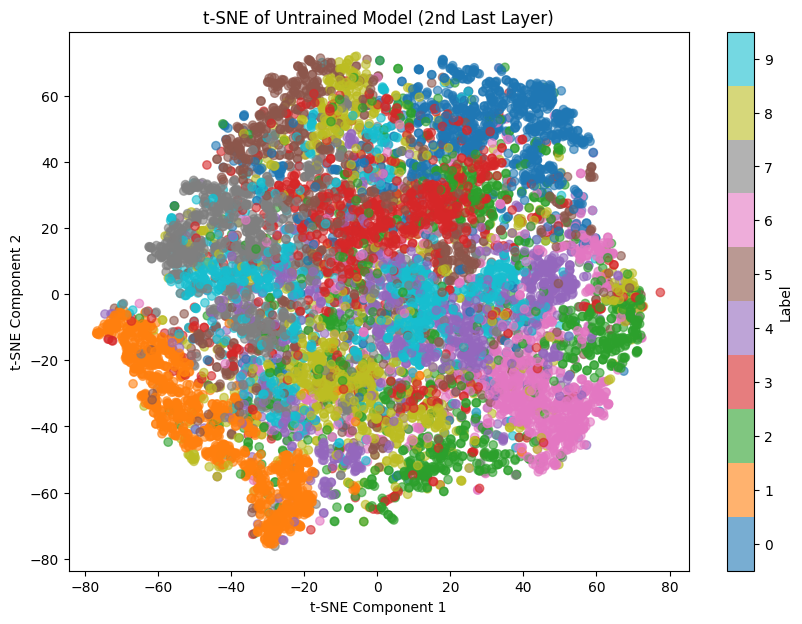

/tmp/ipykernel_30/4022500379.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 10)  #'tab10' has 10 distinct colors


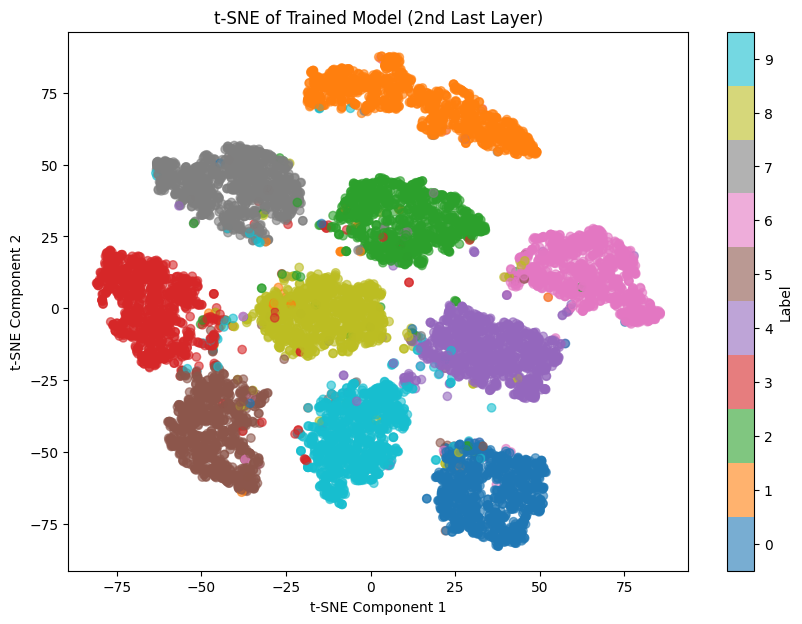

In [160]:
untrained_model = MLP(input_size=28*28)

trained_features, trained_labels = extract_features(model_trained, test_loader)
untrained_features, untrained_labels = extract_features(untrained_model, test_loader)

#Plot t-SNE for the untrained model
plot_tsne(untrained_features, untrained_labels, 't-SNE of Untrained Model (2nd Last Layer)')

plot_tsne(trained_features, trained_labels, 't-SNE of Trained Model (2nd Last Layer)')

# Fashion mnist prediciton

In [161]:
train_images_path_fashion = '/kaggle/input/fashionmnist/train-images-idx3-ubyte'
train_labels_path_fashion = '/kaggle/input/fashionmnist/train-labels-idx1-ubyte'
test_images_path_fashion = '/kaggle/input/fashionmnist/t10k-images-idx3-ubyte'
test_labels_path_fashion = '/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte'

def load_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [162]:
X_train_fashion = load_idx(train_images_path_fashion)
y_train_fashion = load_idx(train_labels_path_fashion)
X_test_fashion = load_idx(test_images_path_fashion)
y_test_fashion = load_idx(test_labels_path_fashion)

In [163]:
print('X_train shape:', X_train_fashion.shape)
print('X_test shape:', X_test_fashion.shape)
print('y_train shape:', y_train_fashion.shape)
print('y_test shape:', y_test_fashion.shape)

X_train shape: (60000, 28, 28)
X_test shape: (10000, 28, 28)
y_train shape: (60000,)
y_test shape: (10000,)


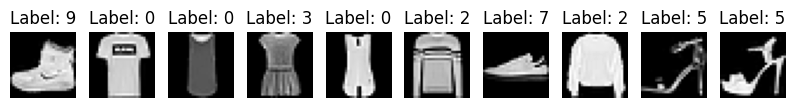

In [164]:
def plot_images(images, labels, num_images=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

plot_images(X_train_fashion, y_train_fashion, num_images=10)#plotting first 10 images

In [165]:
#train-test split = 86-14 (approx), transforming them to torch tensors
X_train_torch_fashion = torch.from_numpy(X_train_fashion) #pointless 
y_train_torch_fashion = torch.from_numpy(y_train_fashion) #pointless 
X_test_torch_fashion = torch.from_numpy(X_test_fashion)
y_test_torch_fashion = torch.from_numpy(y_test_fashion)

In [166]:
X_test_torch_fashion = X_test_torch_fashion.view(-1, 28*28)  #Reshape to (10000, 784)
    
batch_size = 64  
test_dataset = TensorDataset(X_test_torch_fashion, y_test_torch_fashion)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [167]:
def test_model(model, test_loader, criterion):
    #Set the model to evaluation mode
    model.eval()
    
    test_loss = 0
    correct = 0

    #Disable gradient computation
    with torch.no_grad():
        for X_test, y_test in test_loader:
            # Forward pass
            y_pred_test = model(X_test.float())  # Convert input to float
            loss = criterion(y_pred_test, y_test.long())  # Convert labels to long
            test_loss += loss.item()

            # Calculate the number of correct predictions
            _, predicted = torch.max(y_pred_test, 1)
            correct += (predicted == y_test).sum().item()

    #Calculate average loss and accuracy
    test_loss /= len(test_loader)
    test_accuracy = correct / len(test_loader.dataset)

    #Print test results
#     print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')
    
    return test_loss, test_accuracy 

In [168]:
criterion = nn.CrossEntropyLoss()
loss_fashion, accuracy_fashion = test_model(model_trained, test_loader, criterion)
print(f"The loss of the MNIST trained MLP on Fashion MNIST is {loss_fashion:.4f} and the accuracy is {accuracy_fashion*100:.2f}%")

The loss of the MNIST trained MLP on Fashion MNIST is 13.4268 and the accuracy is 3.73%
